### ECG - Synthetic Dataset and Encodings for Diffusion Models

In this notebook we will build and demonstrate the methods that help use with creating a synthetic dataset.

- Timeseries encoding
- Spectrograms
- Generate noisy samples
- Generate embedded data
- Additional datasets

In [3]:
import torch
import torchaudio 
import wfdb
import os
import sys
import wfdb
import numpy as np
import pywt
import random
import string
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import stft
from wfdb import processing
from pyts.image import MarkovTransitionField

print('Virtual Environment:')
print(sys.prefix)


Virtual Environment:
/Users/piedeboer/Desktop/Thesis/code/signal-denoising/venv


#### Encoding Timeseries for Deep Learning
We can use an alternative approach from this paper (https://arxiv.org/pdf/1506.00327.pdf) also used in a paper that used diffusion models to generate ECG signals (https://arxiv.org/pdf/2303.02475.pdf).

Further researched in this paper (https://www.researchgate.net/figure/Conceptual-block-diagram-of-the-proposed-structure-for-individual-household-power_fig4_338359485)

Not Investigated:
- recurrence plots

In [2]:
# From paper 'Generating ECG using Diffusion Models' (2023)
def rescale_time_series(X):     
    """
    Rescale the time series X to fall within the interval [-1, 1].
    
    Parameters:
    X (array-like): The input time series.
    
    Returns:
    X_rescaled (array-like): The rescaled time series.
    """
    # Min-Max scaling: 
    # https://github.com/devitrylouis/imaging_time_series/blob/master/gramian_angular_field.py
    min_ = np.amin(X)
    max_ = np.amax(X)
    scaled_serie = (2*X - max_ - min_)/(max_ - min_)
    # Floating point inaccuracy!
    scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
    scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

    return scaled_serie

# Load the MTF once
mtf = MarkovTransitionField()

# Embedd 
def ecg_to_ggm(X):
    # Rescale
    X = rescale_time_series(X)

    # Calculate the radius values 'r' using the time stamps
    r = np.arange(1, len(X) + 1) / len(X)

    # Calculate the angular values 'phi' using the rescaled time series
    phi = np.arccos(X)

    # Compute GASF matrix
    N = len(X)
    GASF = np.zeros((N, N))
    N = len(X)
    GADF = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            GASF[i, j] = np.cos((phi[i] + phi[j]) / 2)
            GADF[i, j] = np.cos((phi[i] - phi[j]) / 2)
    
    # Compute MTF matrix
    MTF = mtf.transform(X.reshape(1,-1))
    MTF = MTF[0]

    # Return Tensor (3,x,x) 'RGB'
    ggm = np.stack((GASF, GADF, MTF),axis=-1)
    x = torch.tensor(ggm)
    x = torch.permute(x, (2, 0, 1))

    return x  

# Reconstruct
def ggm_to_ecg(ggm):

    # Convetr to numpy
    ggm = ggm.numpy()

    # Fix permutation
    ggm = x.permute(1, 2, 0)

    print('Type  of ggm', type(ggm))
    print('Shape of GGM', ggm.shape)

    # Extract GASF channel
    gasf_channel = ggm[:, :, 0]
    
    # Extract diagonal elements
    diagonals = np.diagonal(gasf_channel)

    return diagonals

#### Spectrograms

Square tensors (spectrograms) are obtained by taking the right values for samples_to, n_fft and hop_length.

A bigger problem is the reconstruction part. We lose phase information, which means we will have to work with a lossy reconstruction. PytorchAudio has a Griffin Lim implementation we use for now. The probably best approach would be to use gradient ascent. Additional recources.

- https://pytorch.org/audio/stable/transforms.html
- https://reference.wolfram.com/language/ref/InverseSpectrogram.html
- https://de.mathworks.com/help/signal/ug/signal-recovery-with-differentiable-scalograms-and-spectrograms.html#SignalRecoveryWithDifferentiableSPExample-1 

Approach 1:

- Using lossy conversion with Griffin [PytorchAudio]

In [6]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def visualize_tensor(tensor):
    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # Transpose the array to (H, W, C) format
    image_array = image_array.transpose(1, 2, 0)

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis
    plt.show()


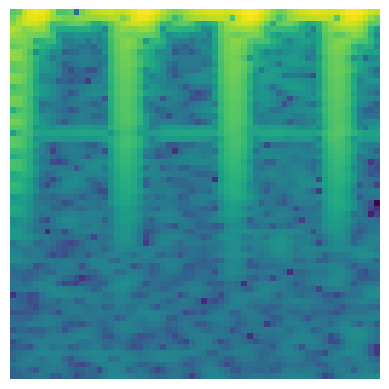

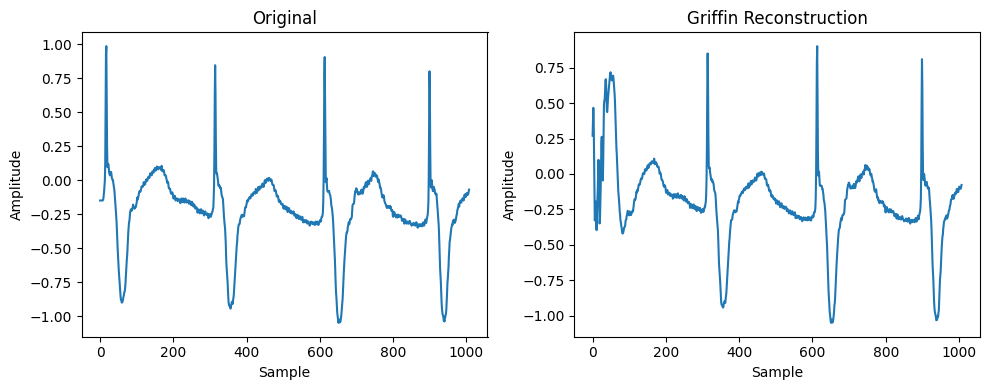

Number of samples: 1008
Duration in seconds: 2.8
Shape of spectrogram: torch.Size([1, 64, 64])


In [8]:
def ecg_to_spectrogram_log(ecg_signal, n_fft=32, hop_length=4):
    """
    Convert ECG signal to spectrogram using torchaudio library.

    Args:
    - ecg_signal (torch.Tensor): 1D tensor representing the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Spectrogram of the ECG signal.
    """
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(ecg_signal)

    # Take the log
    spec = spectrogram[0]
    spec_log = torch.log10(spec)

    return spec_log

def spectrogram_log_to_ecg(spec_log, n_fft=32, hop_length=None,n_iter=400):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
    # Undo log operation
    spec = torch.pow(10, spec_log)

    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=n_fft,  n_iter=400, hop_length=hop_length)(spec)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal

######### Parameters ##########
samples_to = (62*16) + 16
n_fft = 126
hop_length = 16

# Load Data
path_102 = "data/ardb/104"
record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
signal_102 = record_102[0][:, 0]
signal_102 = signal_102

# Build and Visualize Spectrogram
sig = torch.tensor(signal_102)
spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
visualize_tensor(spek_log)

# Visualize reoncstruction using Griffin...
reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
reconstructed_sig = -reconstructed_sig                                        # flip phase for whatever reason...
plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# Info
print('Number of samples:', samples_to)
print('Duration in seconds:', samples_to/360)
print('Shape of spectrogram:',spek_log.shape)


#### Generate Noisy Samples

Since our goal is to use a supervised learning (e.g. diffusion image restauration models). We need to build a training/test set.

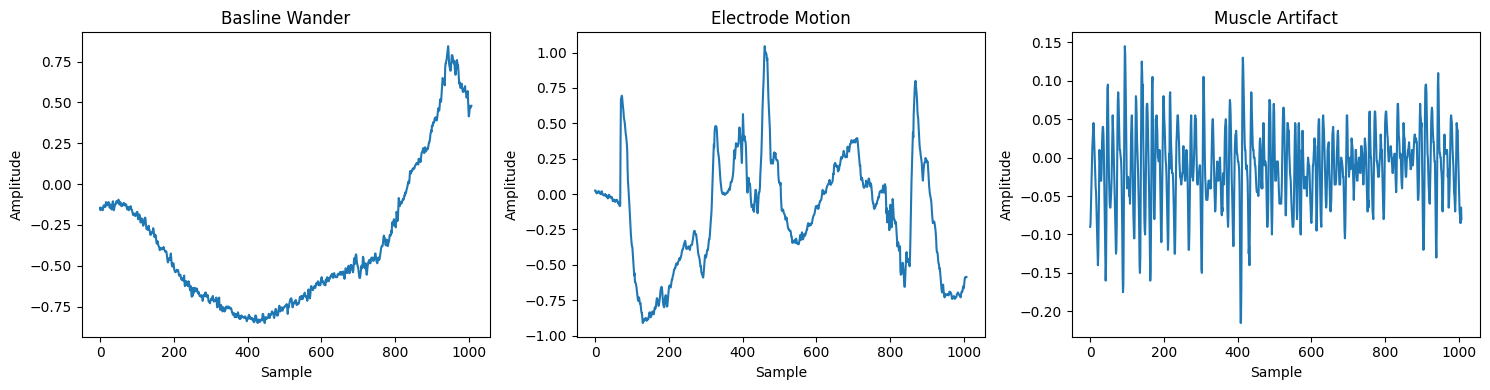

In [10]:
# Extract record
# sampto=128*2*2
sampto=1008
record_bw = wfdb.rdsamp("data/nstdb/bw", sampto=sampto); signal_bw = record_bw[0][:, 0] 
record_em = wfdb.rdsamp("data/nstdb/em", sampto=sampto); signal_em = record_em[0][:, 0]
record_ma = wfdb.rdsamp("data/nstdb/ma", sampto=sampto); signal_ma = record_ma[0][:, 0]

signals = [signal_bw,signal_em,signal_ma]
names = ['Basline Wander', 'Electrode Motion', 'Muscle Artifact']

# Plot multiple time series
plot_multiple_timeseries(signals,names)

# Plot multiple 2D Embeddings
ecg_to_ggms = [ecg_to_ggm(signal_bw), ecg_to_ggm(signal_em), ecg_to_ggm(signal_ma) ]

We can linearly add noise to the samples and control the $SNR$. We use the strategy used in this paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. In addition to that, we also make a method that adds Guassian Noise.

In [12]:
def add_noise(ecg_signal, noise_signal, snr_dB):
    """
    Add noise to the clean ECG signal.

    Parameters:
    - ecg_signal (ndarray): The clean ECG signal.
    - noise_signal (ndarray): The noise signal to be added.
    - snr_dB (float): The desired signal-to-noise ratio in decibels.

    Returns:
    - noisy_signal (ndarray): The noisy ECG signal.
    """
    # Calculate lambda (λ) based on the desired SNR
    lambda_value = np.sqrt(np.mean(ecg_signal**2)) / (np.sqrt(np.mean(noise_signal**2)) * 10**(0.1 * snr_dB / 2))

    # Generate noisy signal
    noisy_signal = ecg_signal + (noise_signal * lambda_value)

    return noisy_signal


Time for an example and some visualizations!

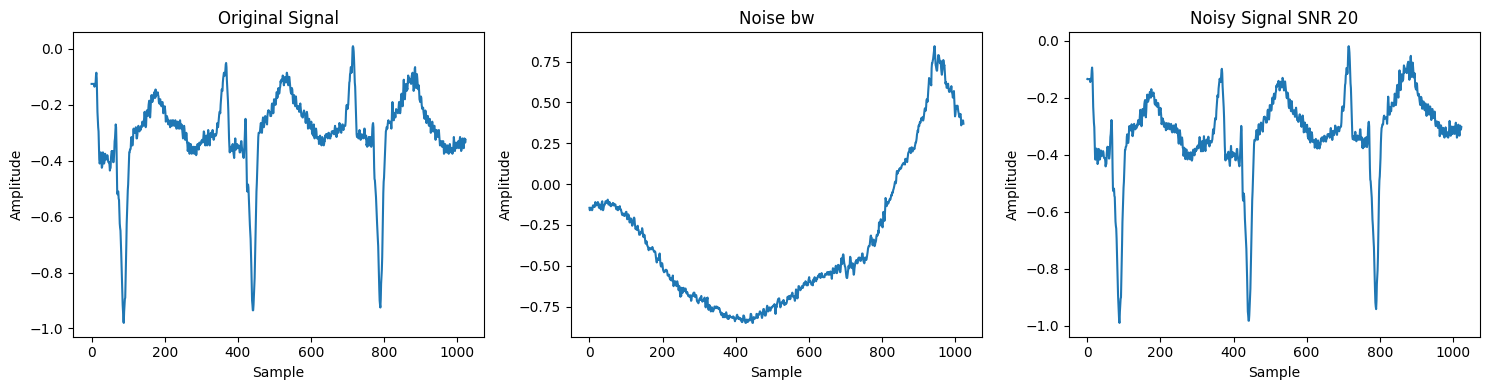

In [13]:
# Define clean ECG signal
sampto=128*2*4
record = wfdb.rdsamp("data/ardb/108", sampto=sampto)
ecg_signal = record[0][:, 0] 

# Define noise signal
path_to_noise = "data/nstdb/bw"
record_noise = wfdb.rdsamp(path_to_noise, sampto=sampto)
noise_signal = record_noise[0][:, 0] 
noise_type = path_to_noise[-2:]

# Desired signal-to-noise ratio (SNR) in decibels
snr_dB = 20  # Example SNR

# Add noise to the clean ECG signal
noisy_signal = add_noise(ecg_signal, noise_signal, snr_dB)

# Different Visualizations...
signals=[ecg_signal, noise_signal,  noisy_signal] 
names=["Original Signal", "Noise "+str(noise_type), "Noisy Signal SNR "+str(snr_dB)]

# Time Series
plot_multiple_timeseries(signals,names)


#### Generate Embedded Data
One paper that works with 1D CCNs uses a 3.0 sec sliding window : https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. I do assume however, if we want to work with 2D CNNs, we will loose too much detail.

An altenative approach of researchers that used diffusion models to generate synthetic hearbeats, was to 'split up' the signal into segmeents with just individual heartbeats (https://arxiv.org/pdf/2306.01875.pdf). They did this based on 270 samples, which corresponds to 0.75 seconds, given a sampling rate of 360. However, since certain noise types can clearly affect multiple heartbeats so we might have to find a middle ground.

Our approach using samples of 540 and keeps the  'hearbeats' intact, important characteristics. While then, we work with 512 samples. We can fix 'full signal recovery' by working with 512 slices, however, our aim is to be able to denoise more challenging noise types. For now, motivating our approach.

-----
TLDR: 
- <font color='orange'>GGM Encoding, Length 512 samples, AM and EM noise, SNR=5</font> 
- <font color='cyan'>Spectrogram, Length 1008 samples, AM and EM noise, SNR=5</font> 

In [14]:
import wfdb
import matplotlib.pyplot as plt

# Define sampto
sampto = 128 * 10

# Read the ECG signal from the record
record = wfdb.rdsamp("data/ardb/104", sampto=sampto)
ecg_signal = record[0][:, 0]

# Define the length of a cardiac cycle
cycle_length = 270 

# Split the ECG signal into cardiac cycles
cardiac_cycles = []
for i in range(0, len(ecg_signal), cycle_length):
    cycle = ecg_signal[i:i+cycle_length]
    cardiac_cycles.append(cycle)

Our sample length is $650000$ and based on paper we took $270$ as an 'average' duration for an individual heartbeat.

In [17]:
# Read the ECG signal from the record
record = wfdb.rdsamp("data/ardb/104")
ecg_signal = record[0][:, 0]

def slice_ecg_signal(ecg_signal, signal_length, heartbeat_duration, k):
    k_heartbeats = heartbeat_duration * k
    parts_of_interest = signal_length // k_heartbeats
    return [ecg_signal[i * k_heartbeats : (i + 1) * k_heartbeats] for i in range(parts_of_interest)]

If we define our length/ number of heartbeats, we can slice the indivual records to obtain many smaller signals/slices.

In [71]:
# Define Variables
signal_length = 650000
heartbeat_duration = 270
k = 2

# Function to read ECG signals from .dat files and generate slices
def generate_slices(folder_path):
    # Initialize an empty dictionary to store slices
    slices_dict = {}

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.dat'):
            # Extract the record number from the file name
            record_number = file_name.split('.')[0]

            # Read the ECG signal from the .dat file
            record = wfdb.rdsamp(os.path.join(folder_path, record_number))
            ecg_signal = record[0][:, 0]

            # Generate slices
            slices = slice_ecg_signal(ecg_signal,signal_length,heartbeat_duration,k)

            # Add slices to the dictionary
            slices_dict[record_number] = slices

    return slices_dict

# Folder path containing the .dat files
folder_path = "data/ardb"

#  Noisebaselinewander.
record_bw = wfdb.rdsamp("data/nstdb/bw")
noise_bw = record_bw[0][:, 0]

# Generate slices and create dictionary
slices_dict_clean = generate_slices(folder_path)

# Print the dictionary
for record_number, slices in slices_dict_clean.items():
    print(f"Record Number: {record_number}, Number of Slices: {len(slices)}")

Record Number: 100, Number of Slices: 1203
Record Number: 101, Number of Slices: 1203
Record Number: 102, Number of Slices: 1203
Record Number: 103, Number of Slices: 1203
Record Number: 104, Number of Slices: 1203
Record Number: 105, Number of Slices: 1203
Record Number: 106, Number of Slices: 1203
Record Number: 107, Number of Slices: 1203
Record Number: 108, Number of Slices: 1203
Record Number: 109, Number of Slices: 1203
Record Number: 111, Number of Slices: 1203
Record Number: 112, Number of Slices: 1203
Record Number: 113, Number of Slices: 1203
Record Number: 114, Number of Slices: 1203
Record Number: 115, Number of Slices: 1203
Record Number: 116, Number of Slices: 1203
Record Number: 117, Number of Slices: 1203
Record Number: 118, Number of Slices: 1203
Record Number: 119, Number of Slices: 1203
Record Number: 121, Number of Slices: 1203
Record Number: 122, Number of Slices: 1203
Record Number: 123, Number of Slices: 1203
Record Number: 124, Number of Slices: 1203
Record Numb

Since we want to build a synthetic dataset (known ground truth), we need both clean- and noisy signals. We can build a new dictionary, that contains the samples, however with noise added. We add the different types of noise at specific SNRs.
- (baseline wander at SNR=5)* skipped for now.. cause the other ones are hard to remove..
- electrode motion at SNR=5
- muscle artificats at SNR=5

In [72]:
# Noise
record_bw = wfdb.rdsamp("data/nstdb/bw", sampto=540)
noise_bw = record_bw[0][:, 0]

record_em = wfdb.rdsamp("data/nstdb/em", sampto=540)
noise_em = record_em[0][:, 0]

record_ma = wfdb.rdsamp("data/nstdb/ma", sampto=540)
noise_ma = record_ma[0][:,0]

# Signal-to-noise ratio
snr = 5

# Build the dictionary with noisy samples
def generate_noisy_samples(slices_dict, noise_sample, snr_dB):
    noisy_samples_dict = {}
    
    # Initialize tqdm to display progress
    pbar = tqdm(total=len(slices_dict), desc="Generating Noisy Samples")
    
    for record_number, slices in slices_dict.items():
        noisy_slices = []
        for slice in slices:
            noisy_slice = add_noise(slice, noise_sample, snr_dB)
            noisy_slices.append(noisy_slice)
        
        # Update the progress bar
        pbar.update(1)
        
        noisy_samples_dict[record_number] = noisy_slices
    
    # Close the progress bar
    pbar.close()
    
    return noisy_samples_dict

slices_dict_noisy_bw_SNR_5 = generate_noisy_samples(slices_dict_clean, noise_bw, snr)  # Since this can be filtered... we focus on the challenging noise types first
slices_dict_noisy_em_SNR_5 = generate_noisy_samples(slices_dict_clean, noise_em, snr)
slices_dict_noisy_ma_SNR_5 = generate_noisy_samples(slices_dict_clean, noise_ma, snr)

mixed_noise = noise_bw + noise_em + noise_em
slices_dict_noisy_mixed_SNR_5 = generate_noisy_samples(slices_dict_clean,mixed_noise,snr)


Generating Noisy Samples:   8%|▊         | 4/48 [00:00<00:02, 19.54it/s]

Generating Noisy Samples: 100%|██████████| 48/48 [00:02<00:00, 20.32it/s]


We can use access our slices for certain records easily and both obtain the clean and noisy slices. From there on we can use our embedding methods, to feed as input to a model. No further need to use this.

In [ ]:
# Example
sig_104_clean = slices_dict_clean.get('105')[0]                   # retrieve first slice clean from record 104
sig_104_noisy_bw = slices_dict_noisy_bw_SNR_5.get('105')[0]       # retreive first slice noisy from record 104
sig_104_noisy_em = slices_dict_noisy_em_SNR_5.get('105')[0]
sig_104_noisy_ma = slices_dict_noisy_ma_SNR_5.get('105')[0]
sig_104_noisy_mixed = slices_dict_noisy_mixed_SNR_5.get('105')[0]

# plot_multiple_timeseries([noise_bw],['Baseline Wander'])
plot_multiple_timeseries([ (noise_bw + noise_em + noise_em)],['Mixed Noise Signal'])

plot_multiple_timeseries([sig_104_clean, sig_104_noisy_bw], ['105 S1 Clean', '105 S1 Noisy BW'])
plot_multiple_timeseries([sig_104_clean, sig_104_noisy_em], ['105 S1 Clean', '105 S1 Noisy EM'])
plot_multiple_timeseries([sig_104_clean, sig_104_noisy_ma], ['105 S1 Clean', '105 S1 Noisy Ma'])
plot_multiple_timeseries([sig_104_clean, sig_104_noisy_mixed], ['105 S1 Clean', '105 S1 Noisy Mixed'])

Since we will work with Pytorch (and Tensorflow) we will convert our dictionaries and then use the library focused structure. By sorting them, we know they correspond to the same original slice.

In [ ]:
# Dictionaries to list
clean_slices_list = [slices_dict_clean[key] for key in sorted(slices_dict_clean.keys())]

noisy_slices_bw_SNR_5_list = [slices_dict_noisy_bw_SNR_5[key] for key in sorted(slices_dict_noisy_bw_SNR_5.keys())]
noisy_slices_em_SNR_5_list = [slices_dict_noisy_em_SNR_5[key] for key in sorted(slices_dict_noisy_em_SNR_5.keys())]
noisy_slices_ma_SNR_5_list = [slices_dict_noisy_ma_SNR_5[key] for key in sorted(slices_dict_noisy_ma_SNR_5.keys())]
noisy_slices_mixed_SNR_5_list = [slices_dict_noisy_mixed_SNR_5[key] for key in sorted(slices_dict_noisy_mixed_SNR_5.keys())]

# Flatten
clean_slices_flat = [slice for sublist in clean_slices_list for slice in sublist]

noisy_slices_bw_SNR_5_flat = [slice for sublist in noisy_slices_bw_SNR_5_list for slice in sublist]
noisy_slices_em_SNR_5_flat = [slice for sublist in noisy_slices_em_SNR_5_list for slice in sublist]
noisy_slices_ma_SNR_5_flat = [slice for sublist in noisy_slices_ma_SNR_5_list for slice in sublist]
noisy_slices_mixed_SNR_5_flat = [slice for sublist in noisy_slices_mixed_SNR_5_list for slice in sublist]

print('Number of noisy samples... mixed noise', len(noisy_slices_mixed_SNR_5_flat))

plot_multiple_timeseries([clean_slices_flat[1000],noisy_slices_mixed_SNR_5_flat[1000]],['Clean', 'Mixed Noise Added'])



Let's work with tensors... 

In [80]:
ggm = ecg_to_ggm(noisy_slices_em_SNR_5_flat[10][:512])

# def to_tensor(ggm):
#     x = torch.tensor(ggm)
#     x = torch.permute(x, (2, 0, 1))
#     return x

# x = torch.tensor(ggm)
# x = torch.permute(x, (2, 0, 1))
print(ggm)

reconstructed  = ggm_to_ecg(ggm)

plot_multiple_timeseries([noisy_slices_em_SNR_5_flat[10],  reconstructed],['original', 'rec'])

def visualize_tensor(tensor):
    """
    Visualize a tensor as an image.
    
    Parameters:
    tensor (torch.Tensor): The input tensor with shape [3, 540, 540].
    """
    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # Transpose the array to (H, W, C) format
    image_array = image_array.transpose(1, 2, 0)

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis
    plt.show()

visualize_tensor(ggm)


tensor([[[-0.4315, -0.4315, -0.4425,  ..., -0.6146, -0.6146, -0.5706],
         [-0.4315, -0.4315, -0.4425,  ..., -0.6146, -0.6146, -0.5706],
         [-0.4425, -0.4425, -0.4534,  ..., -0.6242, -0.6242, -0.5806],
         ...,
         [-0.6146, -0.6146, -0.6242,  ..., -0.7692, -0.7692, -0.7332],
         [-0.6146, -0.6146, -0.6242,  ..., -0.7692, -0.7692, -0.7332],
         [-0.5706, -0.5706, -0.5806,  ..., -0.7332, -0.7332, -0.6949]],

        [[ 1.0000,  1.0000,  0.9999,  ...,  0.9768,  0.9768,  0.9871],
         [ 1.0000,  1.0000,  0.9999,  ...,  0.9768,  0.9768,  0.9871],
         [ 0.9999,  0.9999,  1.0000,  ...,  0.9794,  0.9794,  0.9889],
         ...,
         [ 0.9768,  0.9768,  0.9794,  ...,  1.0000,  1.0000,  0.9985],
         [ 0.9768,  0.9768,  0.9794,  ...,  1.0000,  1.0000,  0.9985],
         [ 0.9871,  0.9871,  0.9889,  ...,  0.9985,  0.9985,  1.0000]],

        [[ 0.7097,  0.7097,  0.7097,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.7097,  0.7097,  0.7097,  ...,  0

AttributeError: 'Tensor' object has no attribute 'eval'

In [ ]:
def ecg_to_spectrogram(ecg_signal, n_fft=400, hop_length=None):
    """
    Convert ECG signal to spectrogram using torchaudio library.

    Args:
    - ecg_signal (torch.Tensor): 1D tensor representing the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Spectrogram of the ECG signal.
    """
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(ecg_signal)

    return spectrogram

def spectrogram_to_ecg(spectrogram, n_fft=400, hop_length=None):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)(spectrogram)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal



sig = torch.tensor(signal_102)
spek = ecg_to_spectrogram(sig)
# visualize_spectrogram(spek)
reconstructed_sig = spectrogram_to_ecg(spek)


#  TODO:
#  - add a method.. visualize spectrogram

These are our new methods, for 'better' spectrograms...

- The new methods

#### Additional Datasets

Assume we want to obtain a bigger dataset... We can additionaly also process the (filtered) data in the ECG-ID dataset: https://physionet.org/content/ecgiddb/1.0.0/ --- However... the samples contain cleaned parts... but are said that the quality is not too great... and sampling frequency 500.

Hold up...
- We can use the real noisy samples here... As 'real' data!

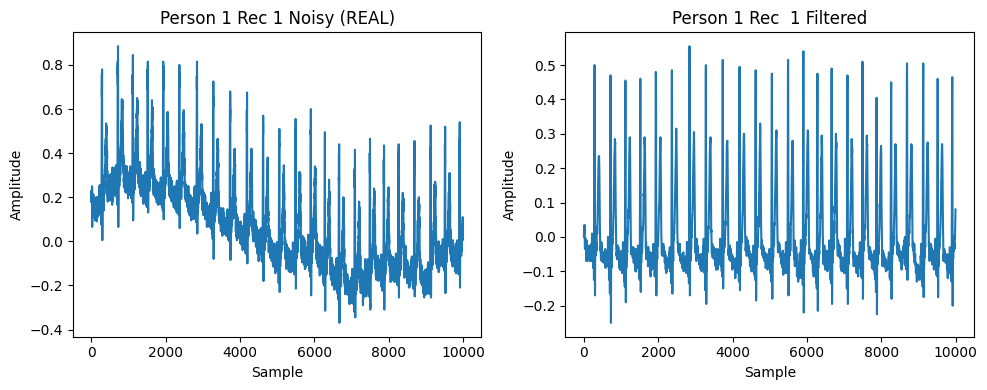

In [ ]:
record_id_p1_rec_1 = wfdb.rdsamp("data/ecg-id-database/Person_63/rec_1")
signal_id_p1_rec_1_noisy = record_id_p1_rec_1[0][:, 0]
signal_id_p1_rec_1_filtered = record_id_p1_rec_1[0][:, 1]

plot_multiple_timeseries([signal_id_p1_rec_1_noisy, signal_id_p1_rec_1_filtered], ['Person 1 Rec 1 Noisy (REAL)', 'Person 1 Rec  1 Filtered'])            # Nice...

Another popular dataset would be: https://physionet.org/content/ptb-xl/1.0.3/ which  was downloaded here at https://www.kaggle.com/datasets/bjoernjostein/ptbxl-electrocardiography-database. We use lead I from this data, and resample to 360 to match our previous data. Might cause some aliasing... Not sure how much this matters.

In [ ]:
%pip install resampy

Note: you may need to restart the kernel to use updated packages.


Length of HR1 5000
Length of HR1 Resample Scipy 3600


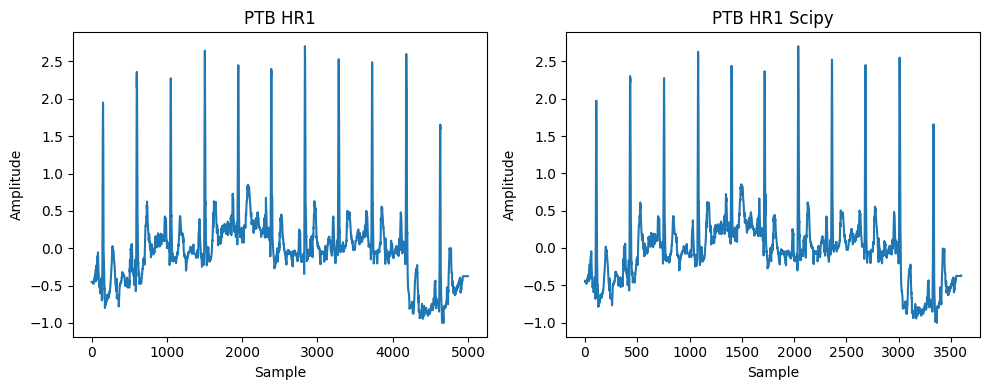

In [ ]:
from scipy.signal import resample

record_ptb_HR1 = wfdb.rdsamp("data/PTB-XL/HR10303")
signal_ptb_HR1 =  record_ptb_HR1[0][:, 0]

# Original sampling rate
original_sampling_rate = 500  # Hz

# Target sampling rate
target_sampling_rate = 360  # Hz

# Resample the signal
num_samples_target = int(len(signal_ptb_HR1) * target_sampling_rate / original_sampling_rate)
resampled_signal_ptb_HR1 = resample(signal_ptb_HR1, num_samples_target)


print('Length of HR1', len(signal_ptb_HR1))
print('Length of HR1 Resample Scipy', len(resampled_signal_ptb_HR1))

plot_multiple_timeseries([signal_ptb_HR1, resampled_signal_ptb_HR1], ['PTB HR1','PTB HR1 Scipy'])

Let us first investigate the model for 57k samples... See how long the training takes.

#### Generative Models: Difffusion Models (and Latent Flow)

Since we like to do something that is somehow original, we can take inspiration from papers that worked with diffusion models for example to generate ECG signals or that use conditional diffusion, but take a slightly different approach. If we feel comfortable, we can look into latent flow model and probably be the first to try this out! Since many papers said there are downsides with GANs, we avoid these. 

We switch to the **src** folder for now and start adapting the SR3 model that is used for super resolution: https://arxiv.org/pdf/2104.07636.pdf.